In [1]:
# Imports
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Função auxiliar para exibir imagens
def show(img, title='', cmap=None):
    plt.figure(figsize=(8,8))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [2]:
# Carregar modelo YOLO
model = YOLO('best.pt')

print("=" * 50)
print("INFORMAÇÕES DO MODELO")
print("=" * 50)
print(f"\nNomes das classes: {model.names}")
print(f"Número de classes: {len(model.names)}")
print(f"\nClasses detectáveis:")
for idx, name in model.names.items():
    print(f"  {idx}: {name}")
print("=" * 50)

INFORMAÇÕES DO MODELO

Nomes das classes: {0: 'brak', 1: 'good'}
Número de classes: 2

Classes detectáveis:
  0: brak
  1: good


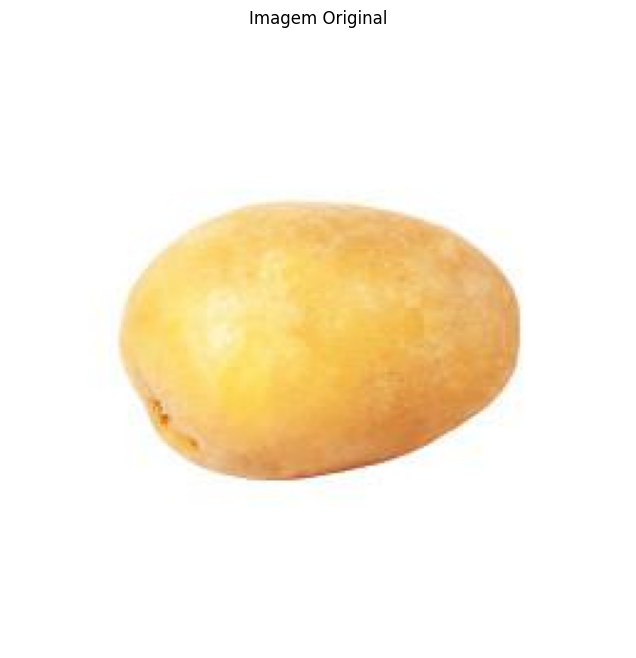

In [3]:
# Carregar imagem
img_path = 'batata-boa.jpg'
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError(f"Imagem não encontrada: {img_path}")

show(img, "Imagem Original")


0: 640x640 1 brak, 1 good, 243.5ms
Speed: 9.4ms preprocess, 243.5ms inference, 17.7ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 1 brak, 1 good, 243.5ms
Speed: 9.4ms preprocess, 243.5ms inference, 17.7ms postprocess per image at shape (1, 3, 640, 640)


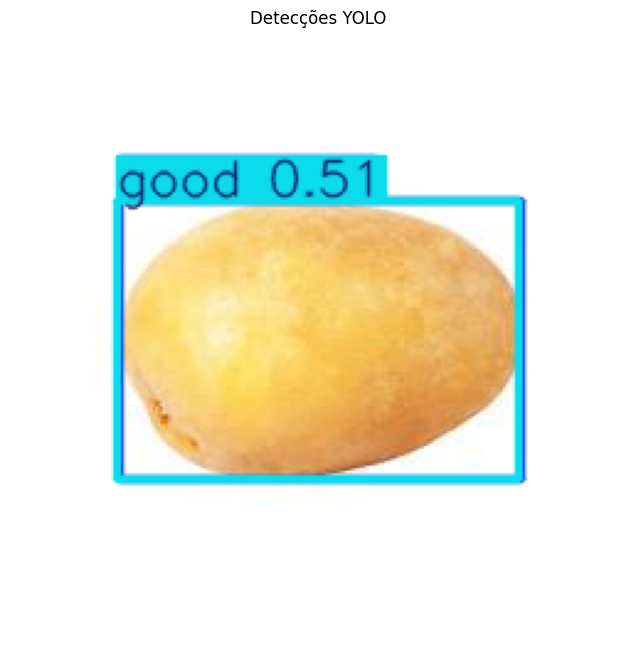


Detectou 2 batata(s):

Batata 1:
  Classe: good
  Confiança: 51.14%
  Coordenadas: x1=43, y1=68, x2=206, y2=181

Batata 2:
  Classe: brak
  Confiança: 49.12%
  Coordenadas: x1=44, y1=68, x2=207, y2=181


In [4]:
# Executar detecção YOLO
results = model(img)

# Processar resultados
for r in results:
    annotated = r.plot()
    show(annotated, "Detecções YOLO")
    
    print(f"\nDetectou {len(r.boxes)} batata(s):")
    
    for i, box in enumerate(r.boxes):
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        xyxy = box.xyxy[0].cpu().numpy()
        
        print(f"\nBatata {i+1}:")
        print(f"  Classe: {r.names[cls]}")
        print(f"  Confiança: {conf:.2%}")
        print(f"  Coordenadas: x1={int(xyxy[0])}, y1={int(xyxy[1])}, x2={int(xyxy[2])}, y2={int(xyxy[3])}")

## Pré-processamento e Segmentação

1. Pré-processamento...


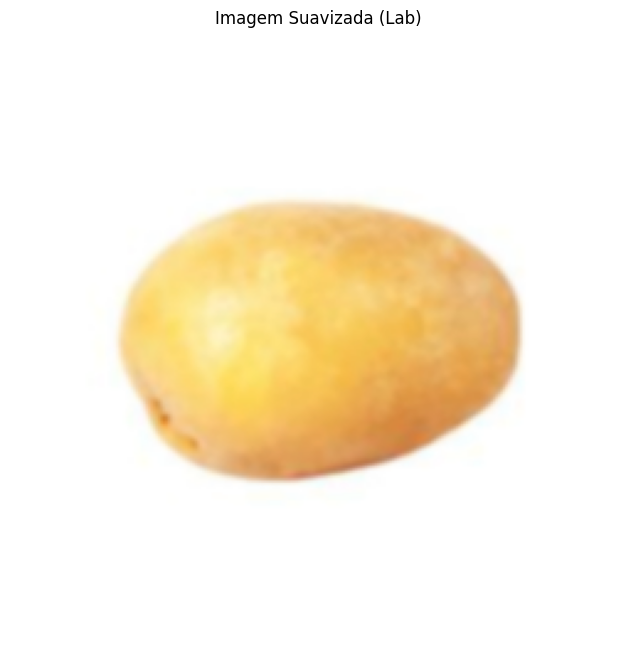

In [5]:
# Pré-processamento
print("1. Pré-processamento...")
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
blur = cv2.GaussianBlur(img_lab, (5,5), 0)

show(cv2.cvtColor(blur, cv2.COLOR_LAB2BGR), "Imagem Suavizada (Lab)")

2. Segmentação...


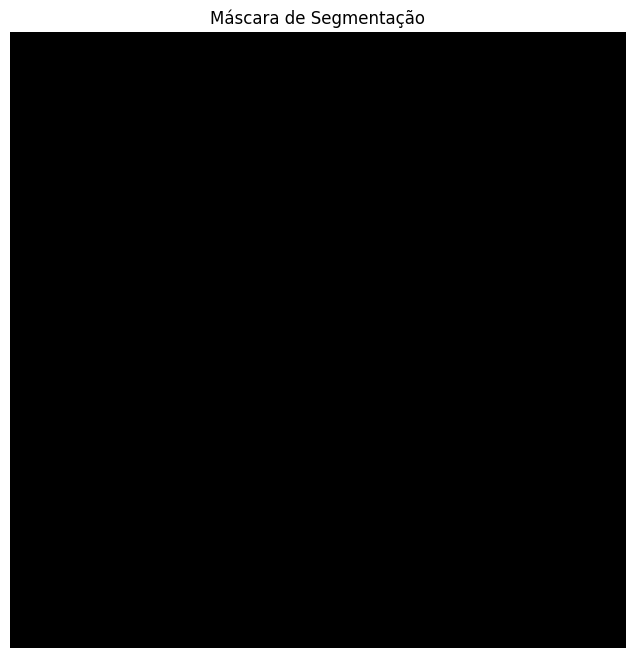

In [6]:
# Segmentação
print("2. Segmentação...")
L, A, B = cv2.split(blur)
_, mask = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

contours, hierarchy = cv2.findContours(mask_clean, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = mask_clean.copy()
for i in range(len(contours)):
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(mask_filled, [contours[i]], -1, 255, -1)

mask = mask_filled
show(mask, "Máscara de Segmentação")

## Análise de Defeitos - Distância de Mahalanobis

In [7]:
# Calcular média e covariância da região saudável
print("3. Calculando média e covariância...")
pixels = blur[mask == 255].reshape(-1, 3)
mean = np.mean(pixels, axis=0)
cov = np.cov(pixels, rowvar=False)
inv_cov = np.linalg.inv(cov)

print(f"Média (Lab): {mean}")
print(f"\nCovariância:\n{cov}")

3. Calculando média e covariância...
Média (Lab): [     243.67      129.57      139.36]

Covariância:
[[     495.93     -91.013     -407.12]
 [    -91.013      20.831      58.613]
 [    -407.12      58.613      430.64]]


4. Calculando distância de Mahalanobis...


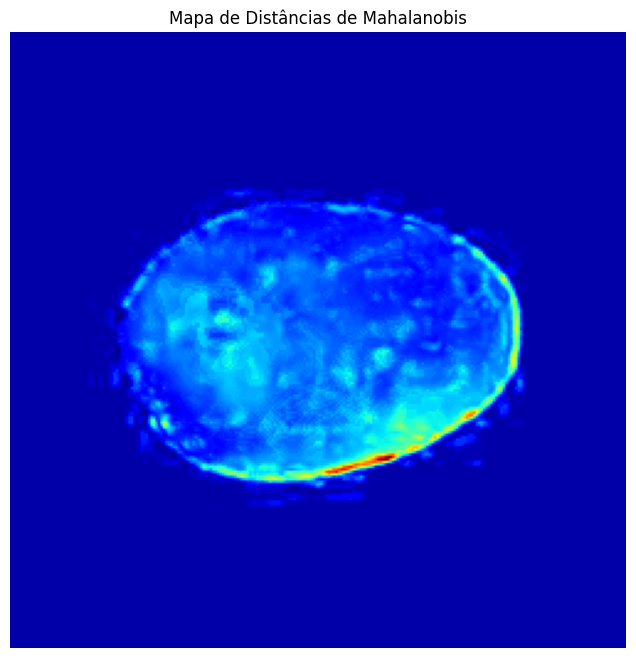

In [8]:
# Calcular distância de Mahalanobis
print("4. Calculando distância de Mahalanobis...")
h, w, c = blur.shape
diff = blur.reshape(-1, 3) - mean
mdist = np.sqrt(np.einsum('ij,jk,ik->i', diff, inv_cov, diff))
mdist_img = mdist.reshape(h, w)
mdist_norm = cv2.normalize(mdist_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

show(mdist_norm, "Mapa de Distâncias de Mahalanobis", cmap='jet')

5. Detectando regiões de defeitos...


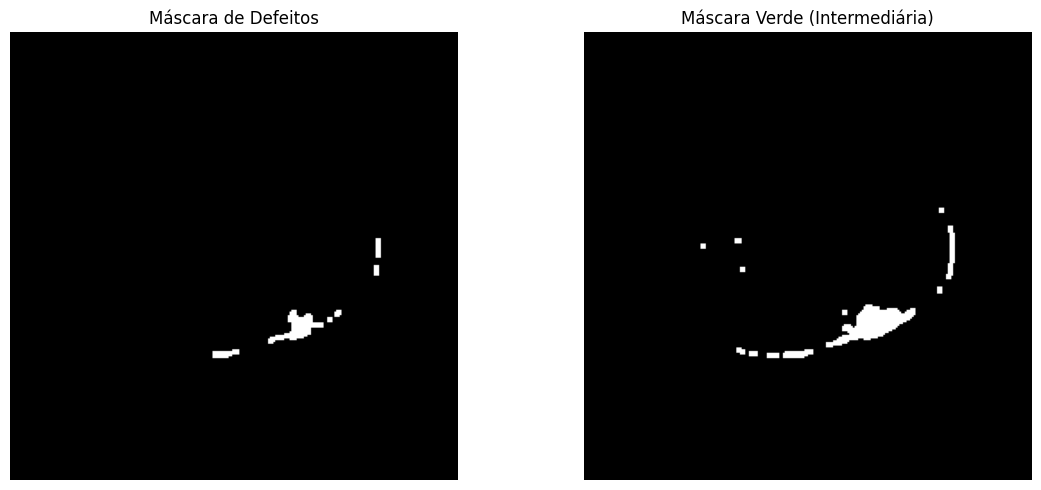

In [9]:
# Detecção de defeitos
print("5. Detectando regiões de defeitos...")
_, exclude_mask = cv2.threshold(mdist_norm, 180, 255, cv2.THRESH_BINARY)
_, defect_mask = cv2.threshold(mdist_norm, 100, 255, cv2.THRESH_BINARY)
defect_mask = cv2.bitwise_and(defect_mask, cv2.bitwise_not(exclude_mask))

kernel_defect = np.ones((3,3), np.uint8)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, kernel_defect)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_CLOSE, kernel_defect)

# Máscara verde (região intermediária)
lower = 90
upper = 180
green_mask = cv2.inRange(mdist_norm, lower, upper)
green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel_defect)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(defect_mask, cmap='gray')
axes[0].set_title('Máscara de Defeitos')
axes[0].axis('off')
axes[1].imshow(green_mask, cmap='gray')
axes[1].set_title('Máscara Verde (Intermediária)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Filtrar Defeitos por Detecções YOLO

6. Criando máscara das detecções YOLO...


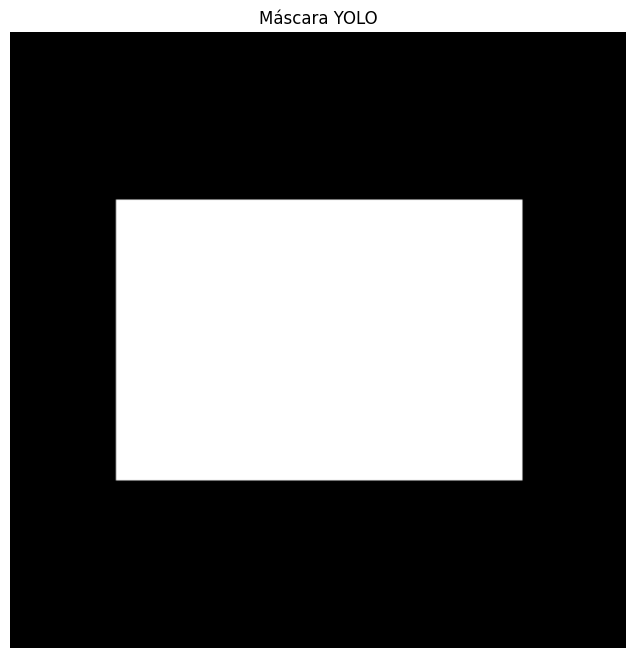

In [10]:
# Criar máscara de detecções YOLO
print("6. Criando máscara das detecções YOLO...")
yolo_mask = np.zeros(img.shape[:2], dtype=np.uint8)
for r in results:
    for box in r.boxes:
        xyxy = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, xyxy)
        cv2.rectangle(yolo_mask, (x1, y1), (x2, y2), 255, -1)

show(yolo_mask, "Máscara YOLO")

7. Filtrando defeitos dentro das batatas detectadas...


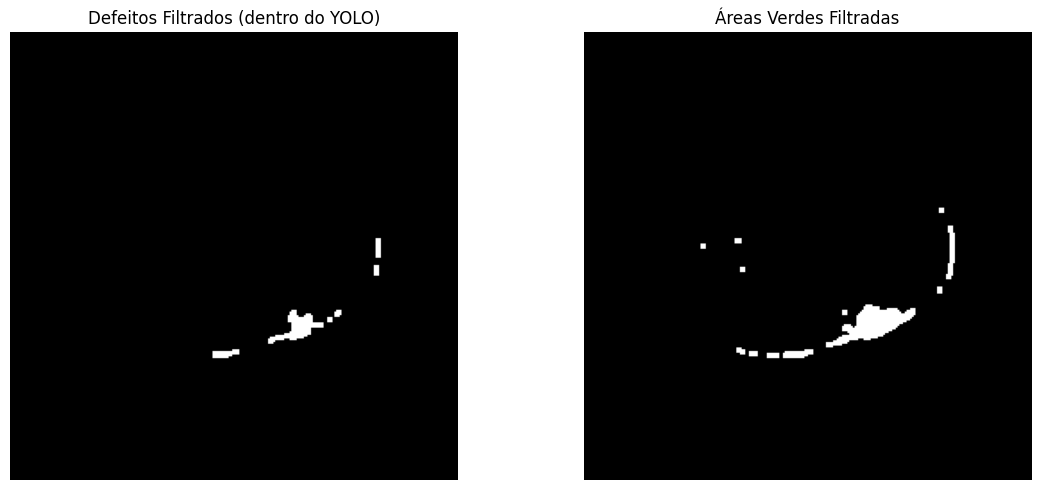

In [11]:
# Filtrar defeitos apenas dentro das detecções YOLO
print("7. Filtrando defeitos dentro das batatas detectadas...")
defect_mask_filtered = cv2.bitwise_and(defect_mask, yolo_mask)
green_mask_filtered = cv2.bitwise_and(green_mask, yolo_mask)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(defect_mask_filtered, cmap='gray')
axes[0].set_title('Defeitos Filtrados (dentro do YOLO)')
axes[0].axis('off')
axes[1].imshow(green_mask_filtered, cmap='gray')
axes[1].set_title('Áreas Verdes Filtradas')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Contagem de Defeitos por Batata

In [12]:
# Contar defeitos por batata detectada
print("\nAnalisando defeitos por batata:")
total_defects = 0

for r in results:
    for idx, box in enumerate(r.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, xyxy)
        
        # Criar máscara apenas desta batata
        single_potato_mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.rectangle(single_potato_mask, (x1, y1), (x2, y2), 255, -1)
        
        # Extrair defeitos apenas dentro desta batata
        defects_in_potato = cv2.bitwise_and(defect_mask, single_potato_mask)
        
        # Contar componentes conectados (defeitos individuais)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(defects_in_potato, connectivity=8)
        
        defect_count = 0
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= 50:  # Área mínima
                defect_count += 1
        
        total_defects += defect_count
        
        # Calcular porcentagem de área com defeito nesta batata
        potato_area_single = (x2 - x1) * (y2 - y1)
        defect_area_single = np.sum(defects_in_potato == 255)
        percent_defect_single = (defect_area_single / potato_area_single) * 100 if potato_area_single > 0 else 0
        
        print(f"\nBatata {idx+1}:")
        print(f"  Defeitos: {defect_count}")
        print(f"  Área com defeito: {percent_defect_single:.2f}%")

print(f"\n✓ Total de defeitos detectados em todas as batatas: {total_defects}")

# Calcular porcentagem de área com defeito (geral)
defect_area = np.sum(defect_mask_filtered == 255)
potato_area = np.sum(yolo_mask == 255)
if potato_area > 0:
    percent_defect = (defect_area / potato_area) * 100
    print(f"✓ Porcentagem da área com defeito (geral): {percent_defect:.2f}%")


Analisando defeitos por batata:

Batata 1:
  Defeitos: 2
  Área com defeito: 1.93%

Batata 2:
  Defeitos: 2
  Área com defeito: 1.93%

✓ Total de defeitos detectados em todas as batatas: 4
✓ Porcentagem da área com defeito (geral): 1.89%


## Visualização Final

8. Gerando visualização final...


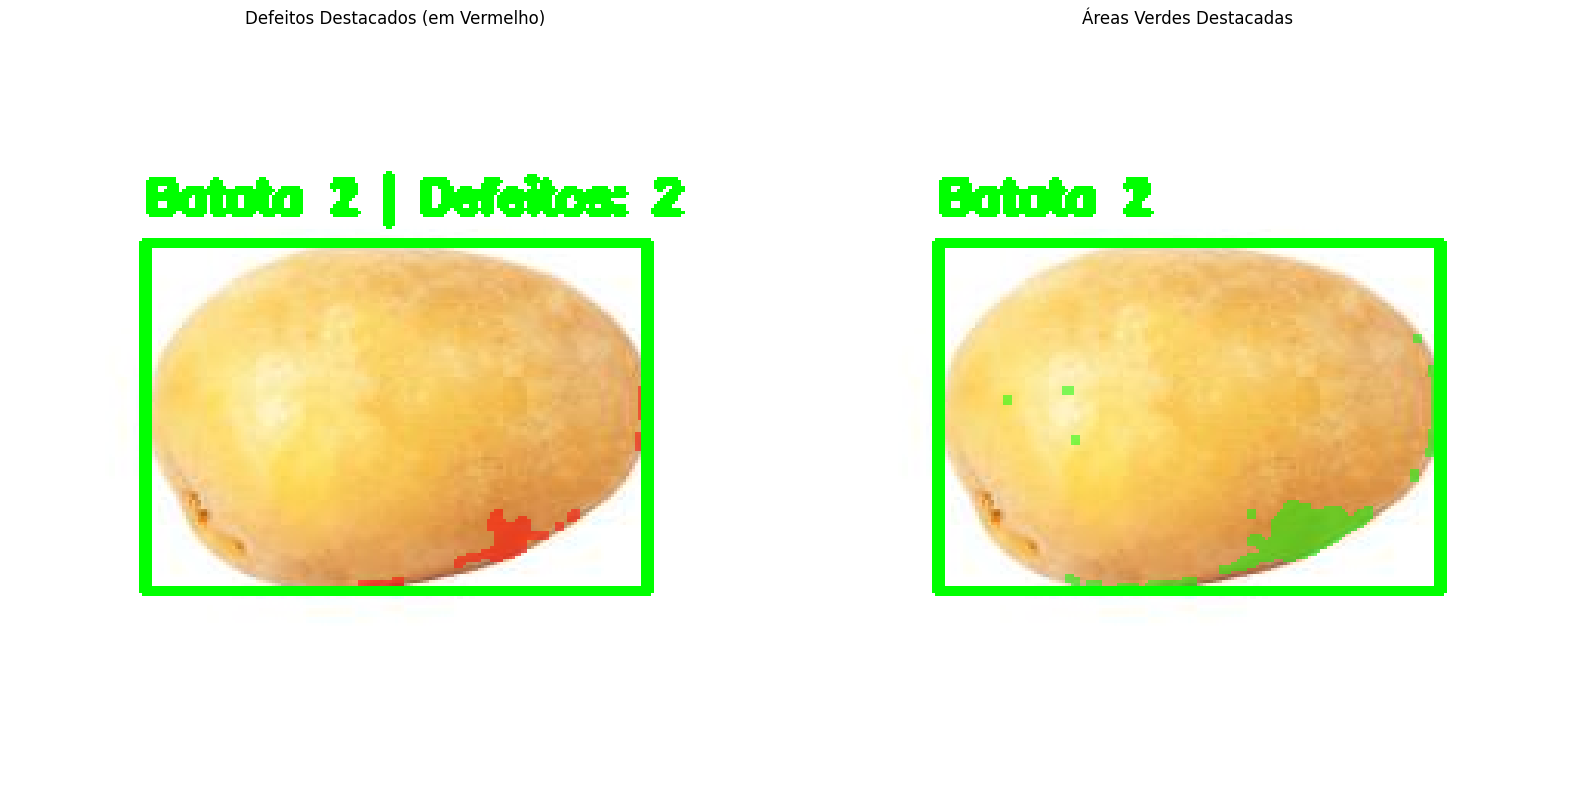

In [13]:
# Gerar visualização final
print("8. Gerando visualização final...")

# Overlay com defeitos em vermelho
overlay = img.copy()
overlay[defect_mask_filtered == 255] = [0, 0, 255]

# Overlay com áreas verdes
overlay_green = img.copy()
overlay_green[green_mask_filtered == 255] = [0, 255, 0]

alpha = 0.5
result = cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)
result_green = cv2.addWeighted(img, 1 - alpha, overlay_green, alpha, 0)

# Adicionar bounding boxes do YOLO com contagem de defeitos
for r in results:
    for idx, box in enumerate(r.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, xyxy)
        conf = float(box.conf[0])
        
        # Contar defeitos nesta batata para o label
        single_potato_mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.rectangle(single_potato_mask, (x1, y1), (x2, y2), 255, -1)
        defects_in_potato = cv2.bitwise_and(defect_mask_filtered, single_potato_mask)
        num_labels_potato, _, stats_potato, _ = cv2.connectedComponentsWithStats(defects_in_potato, connectivity=8)
        defect_count = sum(1 for i in range(1, num_labels_potato) if stats_potato[i, cv2.CC_STAT_AREA] >= 50)
        
        cv2.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.rectangle(result_green, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(result, f'Batata {idx+1} | Defeitos: {defect_count}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(result_green, f'Batata {idx+1}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[0].set_title('Defeitos Destacados (em Vermelho)')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(result_green, cv2.COLOR_BGR2RGB))
axes[1].set_title('Áreas Verdes Destacadas')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Contagem de Defeitos

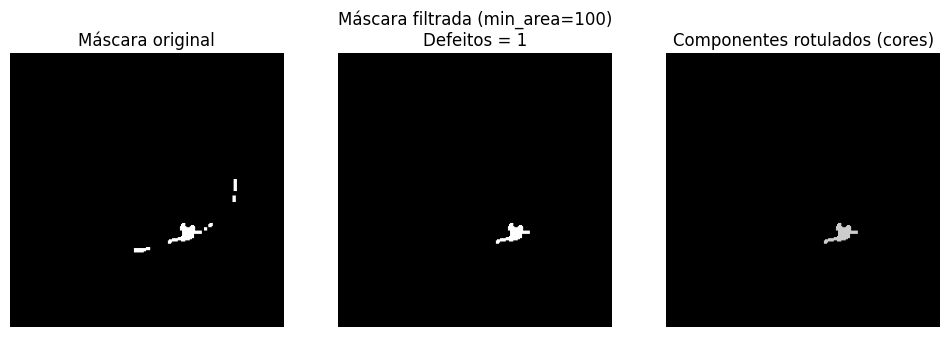

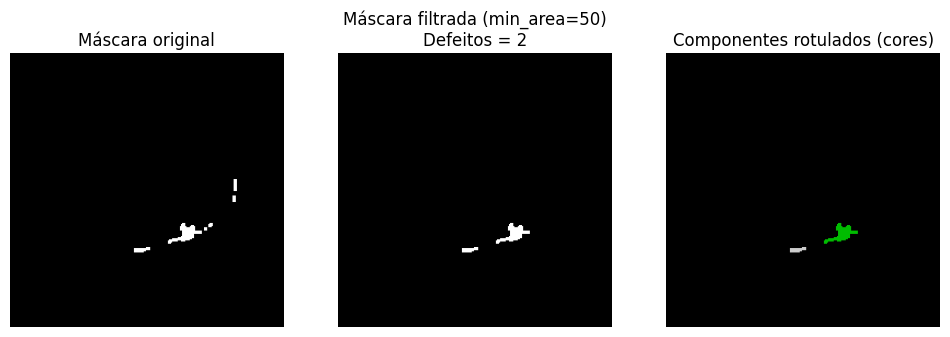

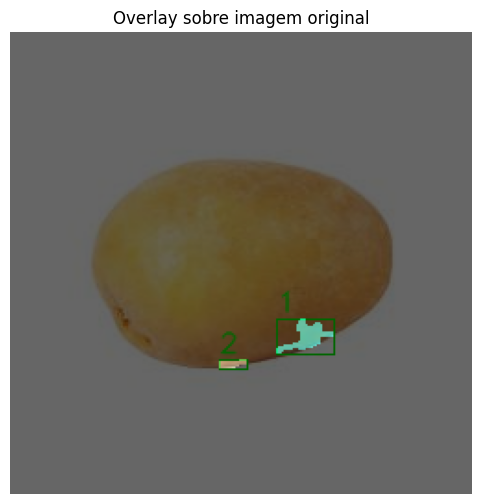

Número de defeitos:  2


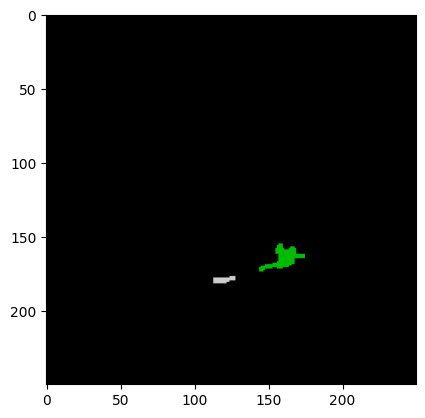

In [ ]:
# Função para contar e analisar defeitos (Connected Components)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def count_defects(mask,
                  min_area=50,
                  connectivity=8,
                  visualize=True,
                  return_stats=False,
                  save_dir=None,
                  overlay_image=None,
                  alpha=0.6):
    
    #  preparar a máscara binária 
    if mask.dtype == np.bool_:
        mask_bin = (mask.astype(np.uint8)) * 255
    else:
        mask_bin = mask.copy()
        # valores entre 0-1 -> escalar
        if mask_bin.max() <= 1:
            mask_bin = (mask_bin * 255).astype(np.uint8)
        else:
            mask_bin = mask_bin.astype(np.uint8)
    # garantir binário
    _, mask_bin = cv2.threshold(mask_bin, 1, 255, cv2.THRESH_BINARY)

    # funçao connected components with stats 
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_bin, connectivity=connectivity)

    # stats: linha por rótulo (inclui 0=fundo): [x, y, width, height, area]
    # filtrar componentes por área (ignorar rótulo 0 - fundo)
    valid_indices = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            valid_indices.append(i)

    num_defects = len(valid_indices)

    # construir máscara filtrada e rotulada com novos rótulos 1..N
    h, w = mask_bin.shape[:2]
    labels_filtered = np.zeros((h, w), dtype=np.int32)
    stats_filtered = []
    centroids_filtered = []

    for new_label, old_label in enumerate(valid_indices, start=1):
        labels_filtered[labels == old_label] = new_label
        stats_filtered.append(stats[old_label].tolist())
        centroids_filtered.append(centroids[old_label].tolist())

    stats_filtered = np.array(stats_filtered) if len(stats_filtered) > 0 else np.zeros((0,5), dtype=np.int32)
    centroids_filtered = np.array(centroids_filtered) if len(centroids_filtered) > 0 else np.zeros((0,2))

    mask_filtered = (labels_filtered > 0).astype(np.uint8) * 255

    # opcional: overlay sobre imagem original
    overlay = None
    if overlay_image is not None:
        # garantir BGR uint8
        img = overlay_image.copy()
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

        # criar uma imagem colorida para as máscaras rotuladas (cada defeito com cor distinta)
        colored = np.zeros_like(img)
        rng = np.random.RandomState(12345)
        colors = [(int(c[0]), int(c[1]), int(c[2])) for c in rng.randint(0, 255, size=(max(1, labels_filtered.max()), 3))]
        for lab in range(1, labels_filtered.max() + 1):
            mask_lab = (labels_filtered == lab)
            colored[mask_lab] = colors[lab - 1]

            # desenhar bounding box e número
            x, y, w_box, h_box, area = stats_filtered[lab - 1]
            cv2.rectangle(img, (x, y), (x + w_box, y + h_box), (0, 255, 0), 1)
            cv2.putText(img, str(lab), (x, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

        # combinar original + colored
        colored_blend = cv2.addWeighted(img, 1 - alpha, colored, alpha, 0)
        overlay = colored_blend

    # visualização
    if visualize:
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.title("Máscara original")
        plt.axis('off')
        plt.imshow(mask_bin, cmap='gray')

        plt.subplot(1,3,2)
        plt.title(f"Máscara filtrada (min_area={min_area})\nDefeitos = {num_defects}")
        plt.axis('off')
        plt.imshow(mask_filtered, cmap='gray')

        plt.subplot(1,3,3)
        plt.title("Componentes rotulados (cores)")
        plt.axis('off')
        # usar mapa de cores para labels_filtered: mostrar 0 como preto
        if labels_filtered.max() > 0:
            plt.imshow(labels_filtered, cmap='nipy_spectral')
        else:
            plt.imshow(labels_filtered, cmap='gray')
        plt.show()

        if overlay is not None:
            plt.figure(figsize=(6,6))
            plt.title("Overlay sobre imagem original")
            plt.axis('off')
            # overlay está em BGR -> converter para RGB para matplotlib
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.show()

    result = {
        'num_defects': num_defects,
        'labels_filtered': labels_filtered,
        'stats_filtered': stats_filtered,
        'centroids_filtered': centroids_filtered,
        'mask_filtered': mask_filtered,
        'overlay': overlay
    }

    if return_stats:
        return result
    else:
        return num_defects


# Exemplo de uso
# Supondo que 'mask' é sua máscara (numpy array) produzida pelo YOLO:
num = count_defects(defect_mask_filtered, min_area=100, connectivity=8, visualize=True)
#
# Para obter estatísticas e overlay:
res = count_defects(defect_mask_filtered, min_area=50, return_stats=True, overlay_image=img)
print("Número de defeitos: ", res['num_defects'])
plt.imshow(res['labels_filtered'], cmap='nipy_spectral')
